In [1]:
# cell 1
# =============================
# 数据准备:原子化拆解
# =============================
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
from dotenv import load_dotenv
import os

# 加载本地.env文件
load_dotenv()

# 从环境变量读取连接信息
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASS")
HOST = os.getenv("DB_HOST","localhost")
PORT = os.getenv("DB_PORT","5432")
DB = os.getenv("DB_NAME")

# 检查读取是否成功(调试用)
if not PASSWORD:
    print("警告:未找到数据库密码,请检查.env文件")
else:
    print("配置加载成功(具体信息已隐藏)")

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# 拉取全量原子数据
# df_items是商品量子化记录表
df_items = pd.read_sql("SELECT * FROM analysis.analysis_items_atomic", engine)
print(f"✅ 原子化数据准备完成。行数: {len(df_items)} (比订单数多，因为包含了 Mixed Basket)")
df_items.head()

配置加载成功(具体信息已隐藏)
✅ 原子化数据准备完成。行数: 110189 (比订单数多，因为包含了 Mixed Basket)


,order_id,order_item_id,product_id,seller_id,price,category,review_score,delay_days,is_late
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,pet_shop,4,-2.0,0
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,furniture_decor,5,-13.0,0
2,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,garden_tools,5,-15.0,0
3,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,21.90,housewares,4,-14.0,0
4,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,19.90,telephony,4,-16.0,0


In [4]:
# cell 2
# ========================================
# 寻找"钩子品类"及数据初步验证 (基于 Item 粒度)
# ========================================
# 钩子:"把用户领进门且留住"的商品,不要求用户第二次必须买同款
# 尤其在Olist这种耐用品为主的平台,"要求同款"会导致样本量归零

# 1. 数据准备
df_rfm = pd.read_sql("SELECT * FROM analysis.analysis_user_rfm", engine)
df_obt = pd.read_sql("SELECT * FROM analysis.analysis_orders_obt", engine)

# 2. 提取复购用户
repurchase_user_ids = df_rfm[df_rfm["frequency"] > 1]["user_id"]
print(f"复购用户总数: {len(repurchase_user_ids)}")

# 3. 寻找复购用户的"第一次下单"
# 3.1 寻找每个用户的首单id
first_orders_map = df_obt.sort_values("purchase_ts").groupby("user_id")["order_id"].first()

# 3.2 筛选出"复购用户"的首单order_id
repurchase_first_order_ids = first_orders_map[first_orders_map.index.isin(repurchase_user_ids)]

# 4. 提取首单购买品类信息
hook_items_pool = df_items[df_items["order_id"].isin(repurchase_first_order_ids)]

# 5. 统计"钩子"
# 统计品类出现次数 (Item Count)
hook_counts = hook_items_pool["category"].value_counts()

print('\n ["钩子品类"验证结果]')
print(f"复购用户首单包含的品类行数: {len(hook_items_pool)}")
print("Top 10 潜在钩子品类 (按从高到低排序):")
print(hook_counts.head(10))

# 6.根据数据进行决策
# 只有当Top品类的样本量足够大(比如>30),我们才能进行关于"钩子品类"的进一步判断分析
top_1_count = hook_counts.iloc[0] if not hook_counts.empty else 0

if top_1_count < 30:
    print(f"\n 样本严重不足! Top 1 品类 ({hook_counts.index[0]}) 仅在 {top_1_count} 个复购用户的首单中出现")
    print("结论: 试图从品类维度寻找规律存在巨大的'随机性风险',建议放弃品类分析，转向供给侧(卖家)分析")
else:
    print(f"\n 头部样本尚可")


复购用户总数: 2801

 ["钩子品类"验证结果]
复购用户首单包含的品类行数: 3416
Top 10 潜在钩子品类 (按从高到低排序):
category
bed_bath_table              498
furniture_decor             393
sports_leisure              303
health_beauty               247
computers_accessories       235
housewares                  188
garden_tools                133
watches_gifts               130
telephony                   114
fashion_bags_accessories    113
Name: count, dtype: int64

 头部样本尚可


大盘平均首单复购转化率: 3.22%
Top 10 高效钩子品类 (按转化率排序):
                          retention_rate  acquisition_users  retained_users
category                                                                   
home_appliances                 0.086510                682            59.0
fashion_bags_accessories        0.061180               1847           113.0
furniture_decor                 0.050677               7755           393.0
bed_bath_table                  0.047986              10378           498.0
sports_leisure                  0.037440               8093           303.0
computers_accessories           0.031973               7350           235.0
garden_tools                    0.031971               4160           133.0
pet_shop                        0.031116               1864            58.0
home_construction               0.029825                570            17.0
office_furniture                0.028711               1637            47.0


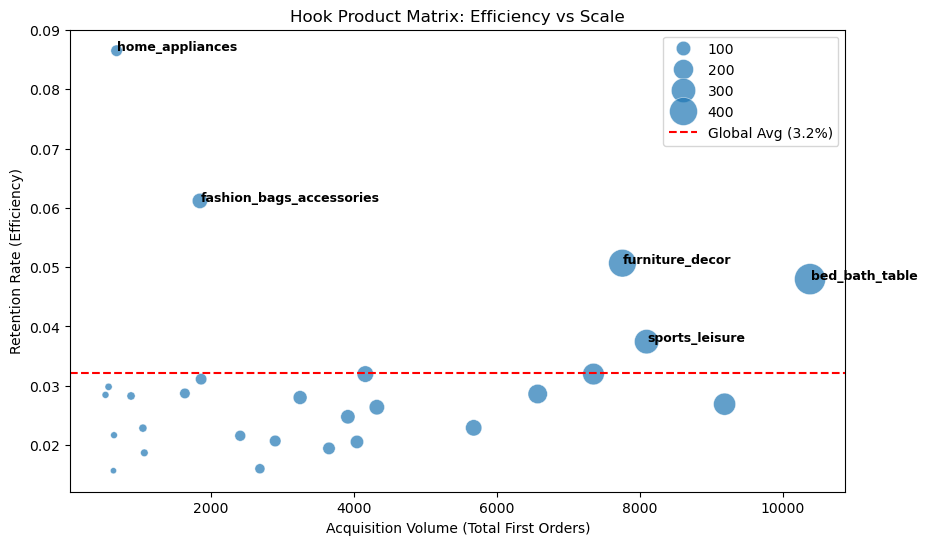

In [5]:
# cell 3
# ==========================================
# 进阶验证: 计算"相对复购效率" 
# ==========================================
# 逻辑:进一步通过"相对复购效率"来筛选出"钩子商品"

# 1. 计算每个品类作为"首单"的总用户数
# 逻辑: 找到所有用户(包括流失的)的首单品类
all_first_orders = df_obt.sort_values("purchase_ts").groupby("user_id")["order_id"].first()
# 关联 Item 表拿到品类
all_first_items = df_items[df_items["order_id"].isin(all_first_orders)]
acquisition_counts = all_first_items["category"].value_counts().rename("acquisition_users")

# 2. 复购用户的首单品类数 (Retained Acquisition)
# 直接用刚刚跑出来的 hook_counts
retention_counts = hook_counts.rename("retained_users")

# 3. 合并并计算转化率
hook_analysis = pd.concat([acquisition_counts, retention_counts], axis=1).fillna(0)
hook_analysis["retention_rate"] = hook_analysis["retained_users"] / hook_analysis["acquisition_users"]

# 4. 过滤小样本 (只看总获客数 > 500 的品类，保证稳健性)
valid_hooks = hook_analysis[hook_analysis["acquisition_users"] > 500].sort_values("retention_rate", ascending=False)

# 5. 计算大盘平均复购率 (Baseline)
global_avg = hook_analysis["retained_users"].sum() / hook_analysis["acquisition_users"].sum()

print(f"大盘平均首单复购转化率: {global_avg:.2%}")
print("Top 10 高效钩子品类 (按转化率排序):")
print(valid_hooks[["retention_rate", "acquisition_users", "retained_users"]].head(10))

# 6. 可视化: 效率 vs 规模矩阵
plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_hooks, x="acquisition_users", y="retention_rate", 
                size="retained_users", sizes=(20, 500), alpha=0.7)

# 画基准线
plt.axhline(global_avg, color="red", linestyle="--", label=f'Global Avg ({global_avg:.1%})')
plt.title('Hook Product Matrix: Efficiency vs Scale')
plt.xlabel('Acquisition Volume (Total First Orders)')
plt.ylabel('Retention Rate (Efficiency)')
plt.legend()

# 标出 Top 5
for i in range(5):
    row = valid_hooks.iloc[i]
    plt.text(row["acquisition_users"]+10, row["retention_rate"], 
             valid_hooks.index[i], weight="bold", fontsize=9)

plt.show()